# Data Pre-processing and Training Data Development

**After thorough Exploratory data analysis, we saved two separate datsets containg data from Kaggle and IMDB. Here in this notebook, we'll carry out pre-processing which includes making data ready for model training. This will include the necessary steps like feature engineering, splitting data into training and test sets.**

In [1]:
# import necessary Python libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# import both datasets
Kaggle = pd.read_csv("clean_datafiles/Kaggledata_ready_for_preprocessing.csv", index_col = 0)
IMDB = pd.read_csv("clean_datafiles/IMDBdata_ready_for_preprocessing.csv", index_col = 0)

In [3]:
Kaggle.head(2)

,title,cast,country,date_added,release_year,duration_min,listed_in,description
1,7:19,"Demián Bichir, Héctor Bonilla, Oscar Serrano, ...",Mexico,2016,2016,93,"Dramas, International Movies",After a devastating earthquake hits Mexico Cit...
2,23:59,"Tedd Chan, Stella Chung, Henley Hii, Lawrence ...",Singapore,2018,2011,78,"Horror Movies, International Movies","When an army recruit is found dead, his fellow..."


In [4]:
IMDB.head(2)

,title,release_year,genre,duration_min,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users
0,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,1.0
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,7.0


In [5]:
Kaggle.columns

Index(['title', 'cast', 'country', 'date_added', 'release_year',
       'duration_min', 'listed_in', 'description'],
      dtype='object')

In [6]:
IMDB.columns

Index(['title', 'release_year', 'genre', 'duration_min', 'country', 'language',
       'director', 'writer', 'production_company', 'actors', 'description',
       'avg_vote', 'votes', 'reviews_from_users'],
      dtype='object')

**Before we do the feature engineering, we'll form two new datasets from existing both datasets. The movies which are common to both datasets will be considered for testing the regression model that will be developed on movies which will only belong to IMDB dataset, but not to Kaggle dataset.**

In [7]:
# Merge both datasets common on 'title' and 'release_year'
common = IMDB.merge(Kaggle, how = 'inner', on = ['title', 'release_year'])

In [8]:
# Make two datasets, one with movies from IMDB which are also in Kaggle "IMDB_Kaggle_common" and another with movies only belong to IMDB dataset "IMDB_only"
IMDB_Kaggle_common = IMDB[IMDB.title.isin(common.title)]
print(IMDB_Kaggle_common.shape)
IMDB_only = IMDB[~(IMDB.title.isin(common.title))]
print(IMDB_only.shape)

(2585, 14)
(69458, 14)


In [9]:
IMDB_Kaggle_common.head(3)

,title,release_year,genre,duration_min,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users
83,Sherlock Holmes,1916,Mystery,116,USA,English,Arthur Berthelet,"H.S. Sheldon, William Gillette",The Essanay Film Manufacturing Company,"William Gillette, Marjorie Kay, Ernest Maupain...",When a couple of swindlers hold young Alice Fa...,6.4,313,10.0
253,Leap Year,1924,Comedy,56,USA,English,"James Cruze, Roscoe 'Fatty' Arbuckle","Walter Woods, Sarah Y. Mason",Paramount Pictures,"Roscoe 'Fatty' Arbuckle, Lucien Littlefield, M...","A young man, heir to his misogynistic and mill...",6.1,268,9.0
300,Phantom,1922,"Drama, Romance",125,Germany,German,F.W. Murnau,"Gerhart Hauptmann, Thea von Harbou",Uco-Film GmbH,"Alfred Abel, Frida Richard, Aud Egede-Nissen, ...",A shiftless young man becomes obsessed with a ...,6.9,1528,19.0


In [10]:
IMDB_only.head(3)

,title,release_year,genre,duration_min,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users
0,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,1.0
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,7.0
3,Cleopatra,1912,"Drama, History",100,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,446,25.0


# Feature Enginerring

In [11]:
# list_unique_values_in_column is function to obtain unique values from categorical column
def list_unique_values_in_column(data_frame, column):
    df = data_frame[column].str.split(',')
    list1 = []
    for i in df:
        list1.extend(each.strip() for each in i)
    return df, set(list1), len(set(list1))

In [12]:
# dummie_variables is a function to create dummie variables for categorical column
def dummie_variables(dataframe, column):
    new_column = dataframe[column].str.split(',').apply(lambda x: [each.strip() for each in x])
    col_names = list_unique_values_in_column(dataframe, column)[1]
    new_dataframe = pd.DataFrame(index = new_column.index, columns = col_names)
    print(new_dataframe.shape)
    new_dataframe[:] = 0
    for i, each in new_column.items():
        new_dataframe.loc[i, each] = 1
    return new_dataframe          

### Getting dummie features for 'genre' column in both new datasets

In [13]:
df_genre = dummie_variables(IMDB_only, 'genre')
df_genre.head()

(69458, 24)


,Fantasy,Musical,Western,Sci-Fi,Drama,Reality-TV,Sport,Crime,News,Music,...,Animation,Horror,Thriller,Mystery,Romance,Family,Adventure,Action,History,Documentary
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df_genre2 = dummie_variables(IMDB_Kaggle_common, 'genre')

(2585, 21)


### Getting dummie features for 'language' column in both new datasets

In [15]:
df_language = dummie_variables(IMDB_only, 'language')
df_language.head()

(69458, 258)


,Awadhi,Ukrainian Sign Language,Esperanto,Hokkien,Korean,Malay,Russian,Himachali,Latvian,Sardinian,...,Tatar,Lithuanian,Frisian,Sinhalese,Sranan,Telugu,Kannada,Polish,Montagnais,Latin
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
df_language2 = dummie_variables(IMDB_Kaggle_common, 'language')

(2585, 112)


**While obtaining the dummy variables, if categorical values are more than 200 unique values, then dummie variables for top 200 unique values will be taken, rest will be discarded.**

In [17]:
# For actor column, keep first two actors and neglect the supporting actor/actoress while carrying out the dummy variables.

In [18]:
IMDB_only.isnull().sum()

title                 0
release_year          0
genre                 0
duration_min          0
country               0
language              0
director              0
writer                0
production_company    0
actors                0
description           0
avg_vote              0
votes                 0
reviews_from_users    0
dtype: int64

In [19]:
IMDB_only_None = IMDB_only[IMDB_only.language == 'None']

In [20]:
IMDB_only_None.shape

(53, 14)

In [21]:
IMDB_only_None.head(2)

,title,release_year,genre,duration_min,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users
0,Miss Jerry,1894,Romance,45,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,154,1.0
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",70,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,589,7.0


###  Getting dummie features for 'actors' column

In [22]:
data_actors = IMDB_only['actors'].str.split(',').apply(lambda i:i[:2])
col_names =  data_actors.apply(lambda x: [each for each in x])

list10 = []
for element in col_names:
    list10.extend(element)
col_names2 = set([x.strip() for x in list10])
len(col_names2)

56155

In [23]:
#data_actors2 = pd.DataFrame(index = col_names.index, columns = col_names2)
#data_actors2[:] = 0
#data_actors2.head()
#MemoryError: Unable to allocate 29.1 GiB for an array with shape (56155, 69458) and data type object

In [24]:
#top_100_actors = []

### Imputation for 'duration_min' column

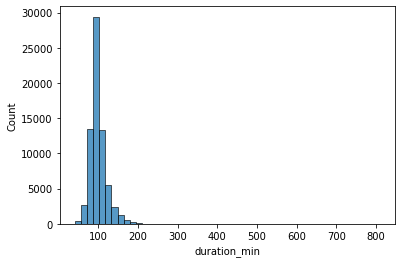

In [25]:
sns.histplot(data = IMDB_only, x = 'duration_min', bins = 50)
plt.show()

In [26]:
# Numerical values with > 90 percentile will be replaced with 90 percentile as a step to take care of the outliers as they are not mistakenly entered.

In [27]:
IMDB_only.duration_min.describe()

count    69458.000000
mean        99.845864
std         21.837568
min         41.000000
25%         88.000000
50%         96.000000
75%        108.000000
max        808.000000
Name: duration_min, dtype: float64

In [28]:
# Numerical values with > 90 percentile will be replaced with 90 percentile as a step to take care of the outliers as they are not mistakenly entered.
IMDB_only.duration_min.quantile(q = [0.05, 0.1, 0.9, 0.95, 0.98, 0.99])

0.05     73.0
0.10     80.0
0.90    125.0
0.95    140.0
0.98    158.0
0.99    170.0
Name: duration_min, dtype: float64

In [29]:
IMDB_only[IMDB_only.duration_min > 125].shape

(6619, 14)

In [30]:
IMDB_only[IMDB_only.duration_min > 170].shape

(668, 14)

In [31]:
IMDB_only[IMDB_only.duration_min > 300].shape

(29, 14)

In [32]:
IMDB_only[IMDB_only.duration_min > 500].shape

(3, 14)

In [33]:
IMDB_only[IMDB_only['duration_min'] > 125] = 125 
IMDB_only.duration_min.describe()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


count    69458.000000
mean        97.683449
std         15.540403
min         41.000000
25%         88.000000
50%         96.000000
75%        108.000000
max        125.000000
Name: duration_min, dtype: float64

In [34]:
IMDB_Kaggle_common[IMDB_Kaggle_common.duration_min > 125] = 125
IMDB_Kaggle_common.duration_min.describe()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


count    2585.000000
mean      105.402321
std        15.264966
min        56.000000
25%        93.000000
50%       104.000000
75%       123.000000
max       125.000000
Name: duration_min, dtype: float64

### Imputation for 'votes' column

In [35]:
IMDB_only.votes.describe()

count    6.945800e+04
mean     7.023577e+03
std      3.750493e+04
min      9.900000e+01
25%      1.760000e+02
50%      4.530000e+02
75%      1.630000e+03
max      1.234134e+06
Name: votes, dtype: float64

In [36]:
IMDB_only.votes.quantile(q = [0.1, 0.5, 0.9, 0.95, 0.98, 0.99, 0.999])

0.100       125.000
0.500       453.000
0.900      8127.300
0.950     25066.850
0.980     80155.280
0.990    145874.190
0.999    562083.902
Name: votes, dtype: float64

In [37]:
IMDB_only[IMDB_only['votes'] > 8127] = 8127 
IMDB_only.votes.describe()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


count    69458.000000
mean      1666.368251
std       2519.800375
min         99.000000
25%        176.000000
50%        453.000000
75%       1630.000000
max       8127.000000
Name: votes, dtype: float64

In [38]:
IMDB_Kaggle_common[IMDB_Kaggle_common['votes'] > 8127] = 8127 
IMDB_Kaggle_common.votes.describe()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


count    2585.000000
mean     3608.041006
std      3567.232269
min       100.000000
25%       161.000000
50%      1715.000000
75%      8127.000000
max      8127.000000
Name: votes, dtype: float64

### Imputation for 'reviews_from_users' column

In [39]:
IMDB_only.reviews_from_users.describe()

count    69458.000000
mean       836.372254
std       2430.544084
min          1.000000
25%          4.000000
50%         12.000000
75%         44.000000
max       8127.000000
Name: reviews_from_users, dtype: float64

In [40]:
IMDB_only.reviews_from_users.quantile(q = [0.1, 0.5, 0.9, 0.95, 0.98, 0.99, 0.999])

0.100       2.0
0.500      12.0
0.900    2910.6
0.950    8127.0
0.980    8127.0
0.990    8127.0
0.999    8127.0
Name: reviews_from_users, dtype: float64

In [41]:
IMDB_only[IMDB_only['reviews_from_users'] > 2910] = 2910 
IMDB_only.votes.describe()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


count    69458.000000
mean      1144.653229
std       1434.473973
min         99.000000
25%        176.000000
50%        453.000000
75%       1630.000000
max       8127.000000
Name: votes, dtype: float64

In [42]:
IMDB_Kaggle_common[IMDB_Kaggle_common['reviews_from_users'] > 2910] = 2910 
IMDB_Kaggle_common.votes.describe()

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


count    2585.000000
mean     1830.022824
std      1663.214717
min       100.000000
25%       161.000000
50%      1715.000000
75%      2910.000000
max      8107.000000
Name: votes, dtype: float64

### Scaling for numrical columns: 'duration_min', 'votes' 'reviews_from_users'

In [43]:
def standard_scaling(df1, df2, col_name):
    scale = StandardScaler()
    df1[[col_name]] = scale.fit_transform(df1[[col_name]])
    df2[[col_name]] = scale.transform(df2[[col_name]])
    return df1, df2   

In [44]:
DurationMin = standard_scaling(IMDB_only, IMDB_Kaggle_common, 'duration_min')
AvgVote = standard_scaling(IMDB_only, IMDB_Kaggle_common, 'votes')
ReviewsFromUsers = standard_scaling(IMDB_only, IMDB_Kaggle_common, 'reviews_from_users')

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [45]:
# Scaling output of 'duration_min' column for IMDB_only dataset
DurationMin[0].head(3)

,title,release_year,genre,duration_min,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users
0,Miss Jerry,1894,Romance,-0.395166,USA,None,Alexander Black,Alexander Black,Alexander Black Photoplays,"Blanche Bayliss, William Courtenay, Chauncey D...",The adventures of a female reporter in the 1890s.,5.9,-0.690609,-0.362228
1,The Story of the Kelly Gang,1906,"Biography, Crime, Drama",-0.365544,Australia,None,Charles Tait,Charles Tait,J. and N. Tait,"Elizabeth Tait, John Tait, Norman Campbell, Be...",True story of notorious Australian outlaw Ned ...,6.1,-0.387360,-0.355299
3,Cleopatra,1912,"Drama, History",-0.329998,USA,English,Charles L. Gaskill,Victorien Sardou,Helen Gardner Picture Players,"Helen Gardner, Pearl Sindelar, Miss Fielding, ...",The fabled queen of Egypt's affair with Roman ...,5.2,-0.487048,-0.334512


In [46]:
# Scaling output of 'duration_min' column for IMDB_Kaggle_common dataset
DurationMin[1].head(3)

,title,release_year,genre,duration_min,country,language,director,writer,production_company,actors,description,avg_vote,votes,reviews_from_users
83,Sherlock Holmes,1916,Mystery,-0.311041,USA,English,Arthur Berthelet,"H.S. Sheldon, William Gillette",The Essanay Film Manufacturing Company,"William Gillette, Marjorie Kay, Ernest Maupain...",When a couple of swindlers hold young Alice Fa...,6.4,-0.579766,-0.351835
253,Leap Year,1924,Comedy,-0.382133,USA,English,"James Cruze, Roscoe 'Fatty' Arbuckle","Walter Woods, Sarah Y. Mason",Paramount Pictures,"Roscoe 'Fatty' Arbuckle, Lucien Littlefield, M...","A young man, heir to his misogynistic and mill...",6.1,-0.611137,-0.352990
300,Phantom,1922,"Drama, Romance",-0.300377,Germany,German,F.W. Murnau,"Gerhart Hauptmann, Thea von Harbou",Uco-Film GmbH,"Alfred Abel, Frida Richard, Aud Egede-Nissen, ...",A shiftless young man becomes obsessed with a ...,6.9,0.267240,-0.341441


In [47]:
IMDB_only_combined = pd.concat([IMDB_only, df_genre, df_language], axis = 1)
IMDB_only_combined.shape

(69458, 296)

In [48]:
IMDB_Kaggle_common_combined = pd.concat([IMDB_Kaggle_common, df_genre2, df_language2], axis = 1)
IMDB_Kaggle_common_combined.shape

(2585, 147)

# Save datasets for model development

In [49]:
IMDB_only_combined.to_csv('pre-processed_dataset/IMDB_only_combined.csv')
IMDB_Kaggle_common_combined.to_csv('pre-processed_dataset/IMDB_Kaggle_common_combined.csv')